1. Clear message connected to message of the paper.
	- Dynamic smoothing stabilizes the Newton/BWGD method
	- Take less points, or initialize further away
2. Explore effect across multiple axes
	- across different dimensions
	- heavy tailed sensing vectors (t distribution, centered exponential), nonidentity covariance
	- Noise
3. All random effects sufficiently averaged out.
4. Easily readable. Distinguishable colors, lines, points. Points are big enough and lines thick enough. Fonts are large enough
5. Legends, grids, axis labels. No titles.

In [7]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
import numpy as np
from tqdm import tqdm

In [8]:
# Take minimum error for all positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

Experimenting with different initializations

In [9]:
def bwgd(y, A, niter=30, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

    # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/2 - np.exp(-y / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde
   
    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde
           
    for iter in range(1, niter):
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y) * At_x / (np.abs(At_x)*n))
        x_tilde -= np.linalg.solve(hessian, gradient)

        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.28it/s]


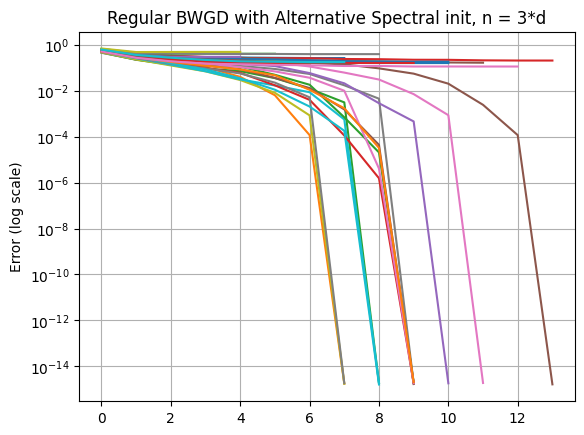

In [4]:
# Plot for d
d = 200
n = int(d * np.log(d))
n = d*3

for j in tqdm(range(1, 31)):  
    # Generate vectors
    x = np.ones(d)/np.sqrt(d)
    A = np.random.randn(d, n)
    y = np.square(A.T @ x)
        
    # Run the algorithm
    x_hat, iter = bwgd(y, A, init="spec2")
    error = min_error(x_hat, x)        
    
    # Plot results
    plt.plot(error)

plt.title('Regular BWGD with Alternative Spectral init, n = 3*d')
plt.ylabel("Error (log scale)")
plt.yscale('log')  
plt.grid(True)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.59it/s]


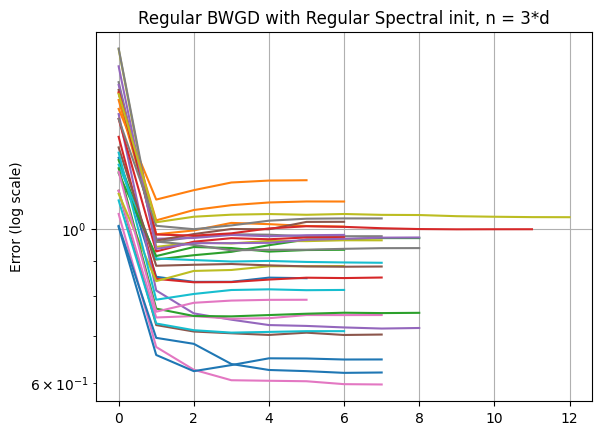

In [5]:
# Plot for d
d = 200
n = int(d * np.log(d))
n=3*d

for j in tqdm(range(1, 31)):  
    # Generate vectors
    x = np.ones(d)/np.sqrt(d)
    A = np.random.randn(d, n)
    y = np.square(A.T @ x)
        
    # Run the algorithm
    x_hat, iters = bwgd(y, A, init="spec1")
    error = min_error(x_hat, x)        
    
    # Plot results
    plt.plot(error)

plt.title('Regular BWGD with Regular Spectral init, n = 3*d')
plt.ylabel("Error (log scale)")
plt.yscale('log')  
plt.grid(True)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.16it/s]


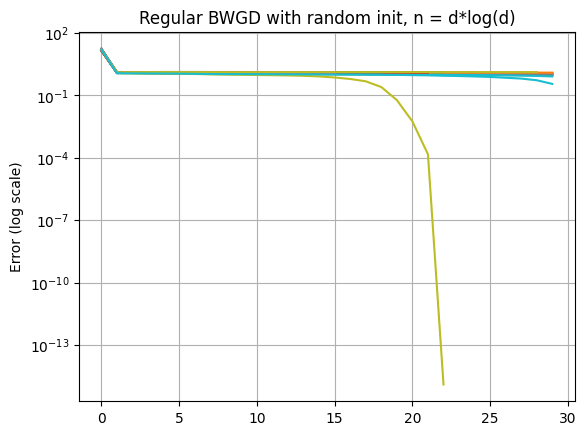

In [26]:
# Plot for d
d = 200
n = int(d * np.log(d))*2

for j in tqdm(range(1, 31)):  
    # Generate vectors
    x = np.ones(d)/np.sqrt(d)
    A = np.random.randn(d, n)
    y = np.square(A.T @ x)
        
    # Run the algorithm
    x_hat, iters = bwgd(y, A, init="rand")
    error = min_error(x_hat, x)        
    
    # Plot results
    plt.plot(error)

plt.title('Regular BWGD with random init, n = d*log(d)')
plt.ylabel("Error (log scale)")
plt.yscale('log')  
plt.grid(True)
plt.show()

Smoothing

In [11]:
def bwgd_smooth(y, A, niter=30, gamma=0.01, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

     # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y**2)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/np.sqrt(3) - np.exp(-y**2 / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde

    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde


    for iter in range(1, niter):
        loss_values = (np.abs(A_tilde.T @ x_tilde) - y) ** 2
        epsilon = np.quantile(loss_values, gamma)

        # Compute values
        row_norms = np.sum(A_tilde**2, axis=0)
        numerator = np.sqrt(y**2 + epsilon * row_norms)
        denominator = np.sqrt(np.sum(A_tilde * ((np.outer(x_tilde,x_tilde) + epsilon * np.eye(d)) @ A_tilde), axis=0))
        alpha = numerator / denominator 

        # Update rule in matrix form
        x_tilde = (1/n) * A_tilde @ (alpha * (A_tilde.T @ x_tilde))
        
        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.10it/s]


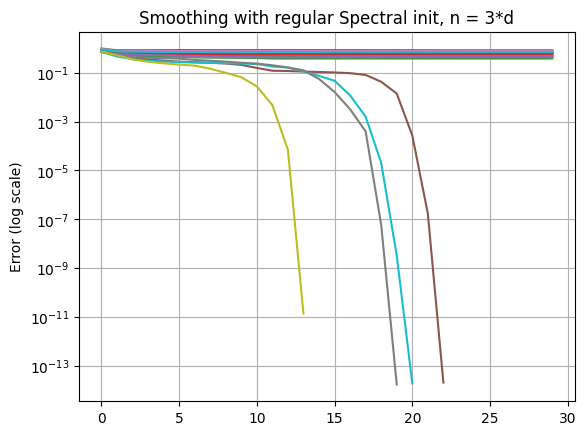

In [8]:
# Plot for d
d = 200
n = int(d * np.log(d))
n=3*d

for j in tqdm(range(1, 31)):  
    # Generate vectors
    x = np.ones(d)/np.sqrt(d)
    A = np.random.randn(d, n)
    y = np.abs(A.T @ x)
        
    # Run the algorithm
    x_hat, iters = bwgd_smooth(y, A, init="spec1")
    error = min_error(x_hat, x)        
    
    # Plot results
    plt.plot(error)

plt.title('Smoothing with regular Spectral init, n = 3*d')
plt.ylabel("Error (log scale)")
plt.yscale('log')  
plt.grid(True)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]


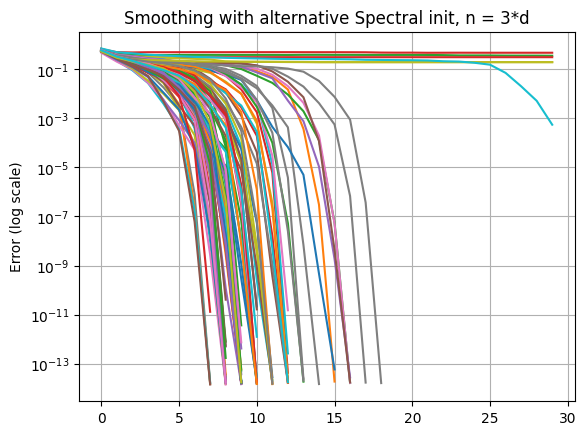

In [9]:
# Plot for d
d = 200
n = int(d * np.log(d))
n= 600

for j in tqdm(range(1, 101)):  
    # Generate vectors
    x = np.ones(d)/np.sqrt(d)
    A = np.random.randn(d, n)
    y = np.abs(A.T @ x)
        
    # Run the algorithm
    x_hat, iters = bwgd_smooth(y, A)
    error = min_error(x_hat, x)        
    
    # Plot results
    plt.plot(error)

plt.title('Smoothing with alternative Spectral init, n = 3*d')
plt.ylabel("Error (log scale)")
plt.yscale('log')  
plt.grid(True)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.74it/s]


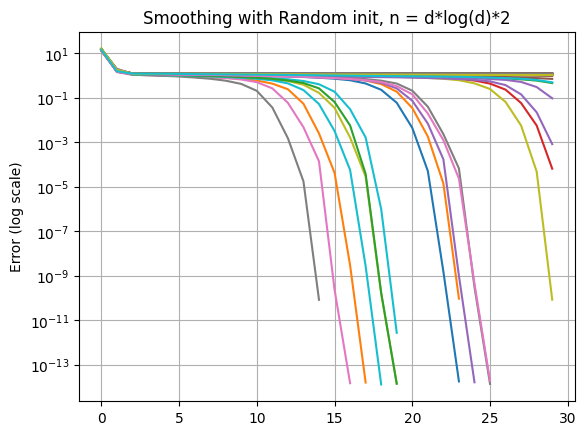

In [10]:
# Plot for d
d = 200
n = int(d * np.log(d))*2

for j in tqdm(range(1, 31)):  
    # Generate vectors
    x = np.ones(d)/np.sqrt(d)
    A = np.random.randn(d, n)
    y = np.abs(A.T @ x)
        
    # Run the algorithm
    x_hat, iters = bwgd_smooth(y, A, init="rand")
    error = min_error(x_hat, x)        
    
    # Plot results
    plt.plot(error)

plt.title('Smoothing with Random init, n = d*log(d)*2')
plt.ylabel("Error (log scale)")
plt.yscale('log')  
plt.grid(True)
plt.show()

Double Histogram of iterations to convergence, x-axis number of iterations y-axis count (smoothing vs no smoothing

In [11]:
def plot_hist(conv_regular, conv_smooth, title):
    bins = np.histogram_bin_edges(conv_regular + conv_smooth, bins=8)
    plt.hist([conv_regular, conv_smooth], bins, label=['Regular', 'Smooth'])
    plt.legend(loc='upper right')
    plt.title(title)
    plt.show()

In [12]:
# Plot for d
d = 200
n = int(d * np.log(d))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


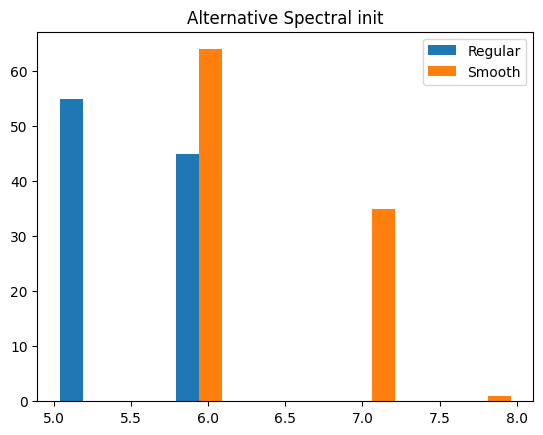

In [13]:
# Plot histograms
conv_regular = []
not_converged_regular = 0
conv_smooth = []
not_converged_smooth = 0

error=[]
for j in tqdm(range(1, 101)):  
    # Generate vectors
    x = np.ones(d)/np.sqrt(d)
    A = np.random.randn(d, n)
    y2 = np.abs(A.T @ x)
    y1 = np.square(A.T @ x)
        
    # Run the algorithm
    x_hat1, iters1 = bwgd(y1, A)
    x_hat2, iters2 = bwgd_smooth(y2, A)

    if min_error(x_hat1, x)[-1]<1e-9:
        conv_regular.append(iters1)
    else:
        not_converged_regular+=1
    if min_error(x_hat2, x)[-1]<1e-9:
        conv_smooth.append(iters2)
    else:
        not_converged_smooth+=1
plot_hist(conv_regular, conv_smooth, "Alternative Spectral init")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s]


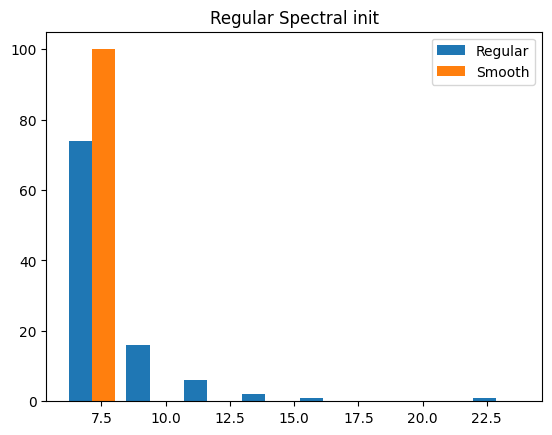

In [14]:
# Plot histograms
conv_regular = []
not_converged_regular = 0
conv_smooth = []
not_converged_smooth = 0

error=[]
for j in tqdm(range(1, 101)):  
    # Generate vectors
    x = np.ones(d)/np.sqrt(d)
    A = np.random.randn(d, n)
    y2 = np.abs(A.T @ x)
    y1 = np.square(A.T @ x)
        
    # Run the algorithm
    x_hat1, iters1 = bwgd(y1, A, init="spec1")
    x_hat2, iters2 = bwgd_smooth(y2, A, init="spec1")

    if min_error(x_hat1, x)[-1]<1e-9:
        conv_regular.append(iters1)
    else:
        not_converged_regular+=1
    if min_error(x_hat2, x)[-1]<1e-9:
        conv_smooth.append(iters2)
    else:
        not_converged_smooth+=1
plot_hist(conv_regular, conv_smooth, "Regular Spectral init")

In [15]:
print("Not converged:", not_converged_regular)

Not converged: 0


Does smoothing help with random initialization + Historgrams. Does using smoothing increase success (random init with and without smoothing)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


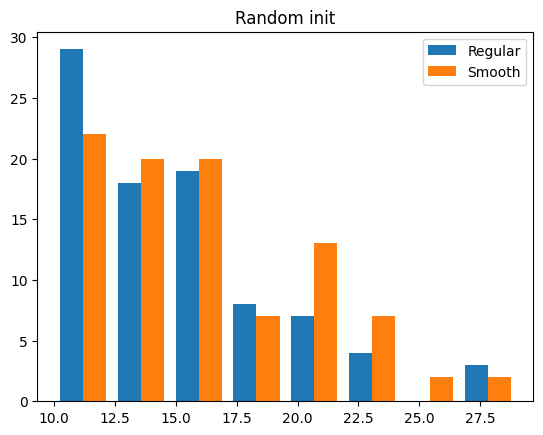

In [16]:
n_random=int(d * np.log(d))*5
# Plot histograms
conv_regular = []
not_converged_regular = 0
conv_smooth = []
not_converged_smooth = 0

error=[]
for j in tqdm(range(1, 101)):  
    # Generate vectors
    x = np.ones(d)/np.sqrt(d)
    A = np.random.randn(d, n_random)
    y2 = np.abs(A.T @ x)
    y1 = np.square(A.T @ x)
        
    # Run the algorithm
    x_hat1, iters1 = bwgd(y1, A, init="rand")
    x_hat2, iters2 = bwgd_smooth(y2, A, init="rand")

    if min_error(x_hat1, x)[-1]<1e-9:
        conv_regular.append(iters1)
    else:
        not_converged_regular+=1
    if min_error(x_hat2, x)[-1]<1e-9:
        conv_smooth.append(iters2)
    else:
        not_converged_smooth+=1
plot_hist(conv_regular, conv_smooth, "Random init")

Spectral Initialization: a's are drawn from heavy tail distribution (Cauchy distribution/ t distribution with 1-degree of freedom).

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.47it/s]


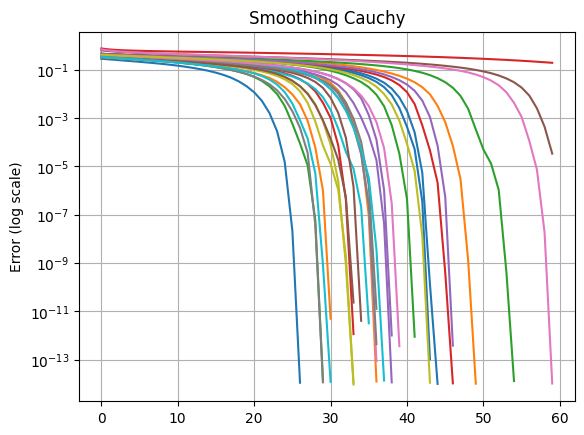

In [36]:
# Plot for d
d = 100
n = int(d*np.log(d))

for j in tqdm(range(1, 31)):  
    # Generate vectors
    x = np.ones(d)/np.sqrt(d)
    A =  np.random.standard_t(5, (d, n))
    y = np.abs(A.T @ x)
        
    # Run the algorithm
    x_hat, iters = bwgd_smooth(y, A, init="spec2",  gamma=0.9, niter=80)
    error = min_error(x_hat, x)        
    
    # Plot results
    plt.plot(error)

plt.title('Smoothing Cauchy')
plt.ylabel("Error (log scale)")
plt.yscale('log')  
plt.grid(True)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.08it/s]


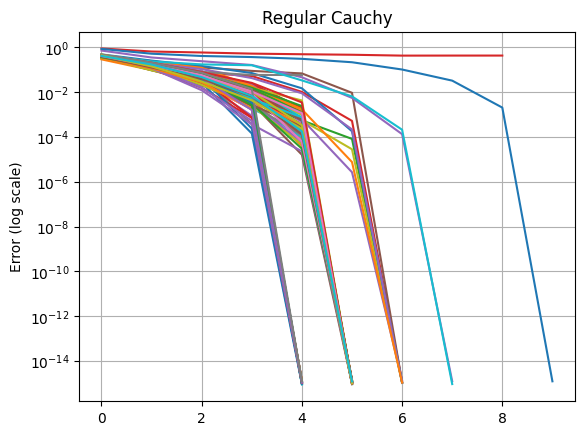

In [38]:
# Plot for d
d = 100
n = int(d*np.log(d))

for j in tqdm(range(1, 101)):  
    # Generate vectors
    x = np.ones(d)/np.sqrt(d)
    A = np.random.standard_t(5, (d, n))
    y = np.square(A.T @ x)
        
    # Run the algorithm
    x_hat, iters = bwgd(y, A,)
    error = min_error(x_hat, x)        
    
    # Plot results
    plt.plot(error)

plt.title('Regular Cauchy')
plt.ylabel("Error (log scale)")
plt.yscale('log')  
plt.grid(True)
plt.show()

Hypothesis: Smoothing is good to guarantee convergence, not necessarily for convergence time

Random Initialization: Sensitive to original to changes in x_true
Original Spectral: Much better when smoothing is used
Alternative Spectral: Works with and without smoothing, and for different x_true


Regular plot: sample size vs %convergence 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.28s/it]


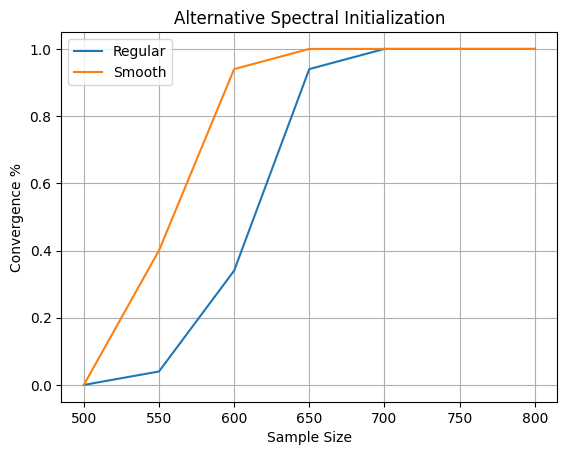

In [21]:
d = 200
ns = [500, 550, 600, 650, 700, 750, 800]
conv_regular = []
conv_smooth = []

for n in ns:
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    
    error=[]
    for j in tqdm(range(1, 51)):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y2 = np.abs(A.T @ x)
        y1 = np.square(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="spec2")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="spec2")
    
        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
    conv_regular.append(conv_regular_number/50)
    conv_smooth.append(conv_smooth_number/50)

plt.plot(ns, conv_regular, label="Regular")
plt.plot(ns, conv_smooth, label="Smooth")
plt.title('Alternative Spectral Initialization')
plt.xlabel("Sample Size")
plt.ylabel("Convergence %")
plt.legend()
plt.grid(True)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.25s/it]


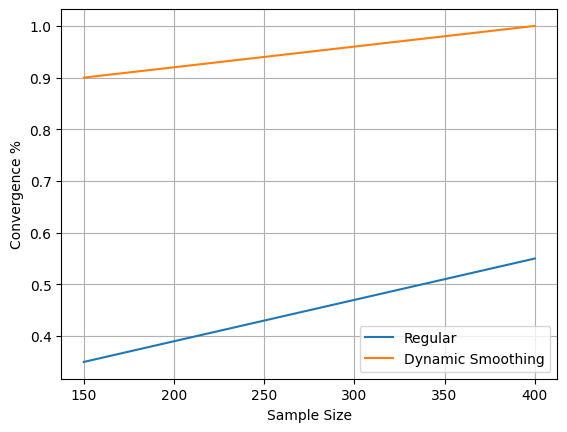

In [31]:
# % of Convergence for higher samples, keeping d=200. Compares smooth and not smooth bwgd with the 2nd spectral initialization
ds = np.linspace(150, 400, 2)
conv_regular = []
conv_smooth = []
iters = 20

for d in tqdm(ds):
    d=int(d)
    n=3*d
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    
    error=[]
    for j in range(iters):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y2 = np.abs(A.T @ x)
        y1 = np.square(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="spec2")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="spec2")
    
        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
    conv_regular.append(conv_regular_number/iters)
    conv_smooth.append(conv_smooth_number/iters)

plt.plot(ds, conv_regular, label="Regular")
plt.plot(ds, conv_smooth, label="Dynamic Smoothing")
plt.xlabel("Sample Size")
plt.ylabel("Convergence %")
plt.legend()
plt.grid(True)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.88it/s]


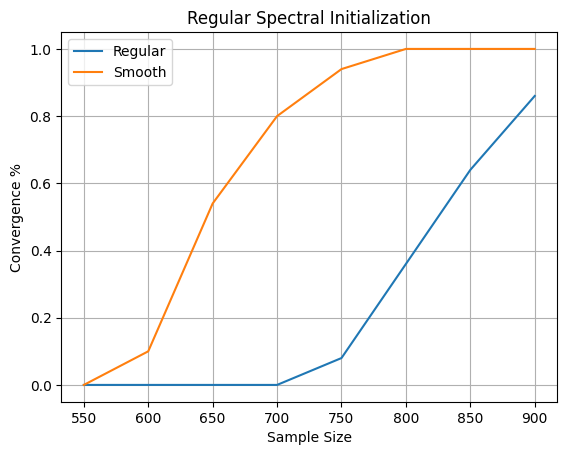

In [21]:
d = 200
ns = [550, 600, 650, 700, 750, 800, 850,900]
conv_regular = []
conv_smooth = []

for n in ns:
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    
    error=[]
    for j in tqdm(range(1, 51)):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y2 = np.abs(A.T @ x)
        y1 = np.square(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="spec1")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="spec1")
    
        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
    conv_regular.append(conv_regular_number/50)
    conv_smooth.append(conv_smooth_number/50)

plt.plot(ns, conv_regular, label="Regular")
plt.plot(ns, conv_smooth, label="Smooth")
plt.title('Regular Spectral Initialization')
plt.xlabel("Sample Size")
plt.ylabel("Convergence %")
plt.legend()
plt.grid(True)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


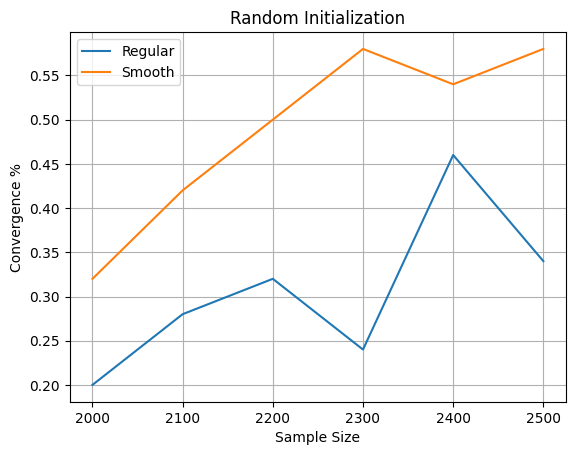

In [22]:
d = 200
ns = [2000, 2100, 2200,2300, 2400,2500]
conv_regular = []
conv_smooth = []

for n in ns:
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    
    error=[]
    for j in tqdm(range(1, 51)):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y2 = np.abs(A.T @ x)
        y1 = np.square(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="rand")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="rand")
    
        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
    conv_regular.append(conv_regular_number/50)
    conv_smooth.append(conv_smooth_number/50)

plt.plot(ns, conv_regular, label="Regular")
plt.plot(ns, conv_smooth, label="Smooth")
plt.title('Random Initialization')
plt.xlabel("Sample Size")
plt.ylabel("Convergence %")
plt.legend()
plt.grid(True)
plt.show()

n vs % overlap. number of sign(atx) are the same for x init and x_star/m. For new and old spectral init

In [23]:
def initialization(y, A, init="spec2"):
    d, n = A.shape

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

     # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/2 - np.exp(-y / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect))     
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]

    elif init == "spec3":
        Y = np.zeros((d, d))
        for i in range(n):
            a_i = A_tilde[:, i]
            norm_ai = np.linalg.norm(a_i)
            if norm_ai > 0:
                Y += (y[i] / norm_ai) * np.outer(a_i, a_i)
        Y /= n
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = eigenvect / np.linalg.norm(eigenvect)
    
    return C_inv @ x_tilde

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:38<00:00, 27.27s/it]


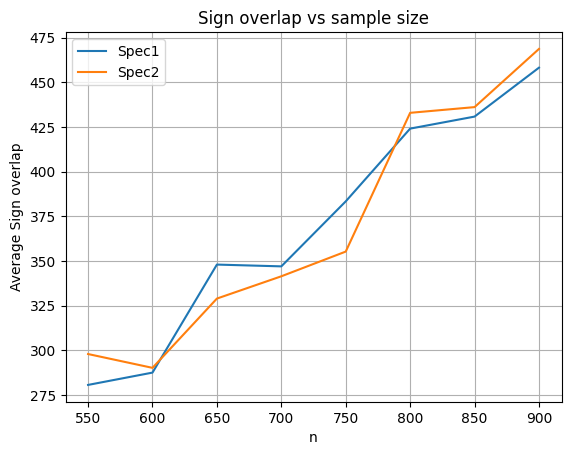

In [24]:
d = 200
ns = [550, 600, 650, 700, 750, 800, 850,900]
sign_spec1 = []
sign_spec2 = []

for n in tqdm(ns):
    signs1 = []
    signs2 = []
    error=[]
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        atx = A.T @ x
        y = np.square(atx)
            
        # Run the algorithm
        x1 = initialization(y, A, init="spec1")
        x2 = initialization(y, A, init="spec2")

        signs1.append(np.sum(A.T@ x1 * atx > 0))
        signs2.append(np.sum(A.T@ x2 * atx > 0))
    
    sign_spec1.append(np.mean(signs1))
    sign_spec2.append(np.mean(signs2))

plt.plot(ns, sign_spec1, label="Spec1")
plt.plot(ns, sign_spec2, label="Spec2")
plt.title('Sign overlap vs sample size')
plt.xlabel("n")
plt.ylabel("Average Sign overlap")
plt.legend()
plt.grid(True)
plt.show()

Plot of initialization error

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:41<00:00, 56.38s/it]


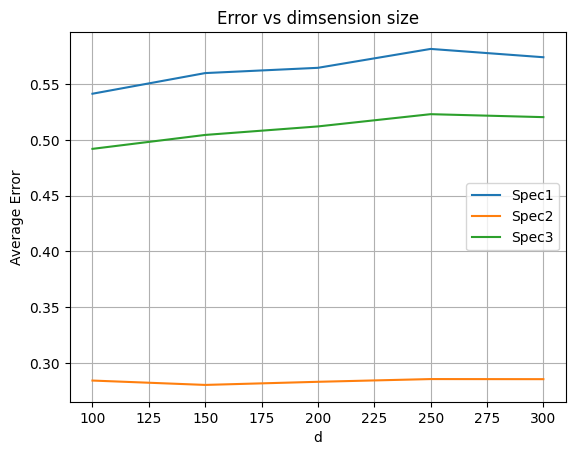

In [25]:
ds = [100, 150, 200, 250, 300]
error_spec1 = []
error_spec2 = []
error_spec3 = []


for d in tqdm(ds):
    n = d*5
    error1 = []
    error2 = []
    error3 = []

    error=[]
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        atx = A.T @ x
        y = np.square(atx)
            
        # Run the algorithm
        x1 = initialization(y, A, init="spec1")
        x2 = initialization(y, A, init="spec2")
        x3 = initialization(y, A, init="spec3")

        error1.append(min_error(x1, x))
        error2.append(min_error(x2, x))
        error3.append(min_error(x3, x))
    
    error_spec1.append(np.mean(error1))
    error_spec2.append(np.mean(error2))
    error_spec3.append(np.mean(error3))


plt.plot(ds, error_spec1, label="Spec1")
plt.plot(ds, error_spec2, label="Spec2")
plt.plot(ds, error_spec3, label="Spec3")
plt.title('Error vs dimsension size')
plt.xlabel("d")
plt.ylabel("Average Error")
plt.legend()
plt.grid(True)
plt.show()